Projekt Uczenie Maszynowe

Import potrzebnych bibliotek

In [2]:
import pandas as pd
import csv
import matplotlib

Import danych.

In [3]:
health = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
health

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Sprawdzenie czy w pliku znajdują się brakujące wartości:

In [4]:
print(health.isnull().mean())

Person ID                  0.000000
Gender                     0.000000
Age                        0.000000
Occupation                 0.000000
Sleep Duration             0.000000
Quality of Sleep           0.000000
Physical Activity Level    0.000000
Stress Level               0.000000
BMI Category               0.000000
Blood Pressure             0.000000
Heart Rate                 0.000000
Daily Steps                0.000000
Sleep Disorder             0.585561
dtype: float64


Widzimy, że kolumna "Sleep Disorder" zawiera brakujące dane.

Odrzucenie kolumn nieistotnych z założenia w naszym modelu, tzn. płeć, zawód. Ta druga kolumna jest odrzucona, ponieważ praca nie ma większego wpływu na jakość snu, poza między innymi wywołanym stresem, który jest już zawarty w zbiorze danych.

In [5]:
health = health.drop('Gender', axis = 1)
health = health.drop('Occupation', axis = 1)
health = health.drop('Person ID', axis = 1)

Opis BMI jest słowny, informuje o tym czy u danej osoby pojawia się nadwaga, niedowaga. Zastosowane zostaje zatem one-hot kodowanie, żeby taka zmiana nie wpłynęła na złą interpretację danych.

Importowanie najpierw biblioteki OneHotEncoded

In [6]:
from sklearn.preprocessing import OneHotEncoder

Tworzenie instancji OneHotEncoder, dopasowanie danych

In [7]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(health[['BMI Category']])

Utworzenie nowej kolumny

In [8]:
health_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['BMI Category']))

Dodanie kolumny do istniejących danych oraz usunięcie kolumny 'BMI Category', która została przekształcona.

In [9]:
health = pd.concat([health, health_encoded], axis=1)
health.drop(columns=['BMI Category'], inplace=True)

In [10]:
health_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['BMI Category']))

Podobna sytuacja pojawia się w przypadku kolumny 'Sleep Disorder'. Znów stosujemy kodowanie one-hot.

In [11]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(health[['Sleep Disorder']])

health_encoded_ = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Sleep Disorder']))

health = pd.concat([health, health_encoded_], axis=1)
health.drop(columns=['Sleep Disorder'], inplace=True)

Usuniemy kolumnę "Sleep Disorder_nan", która zawiera informację o brakujących danych o zaburzeniach snu, więc nie wpłynie na dokładność naszego modelu.

In [12]:
health.drop(columns=['Sleep Disorder_nan'], inplace=True)

Dokonanie podziału ciśnienia krwi na dwie oddzielne kolumny : 'Systolic Pressure', 'Diastolic Pressure'.

In [13]:
health[['Systolic Pressure', 'Diastolic Pressure']] = health['Blood Pressure'].str.split('/', expand=True).astype(int)
health = health.drop('Blood Pressure', axis = 1)

Import bibliotek potrzebnych do wizualizacji korelacji pomiędzy danymi.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

Macierz korelacji:

<Axes: >

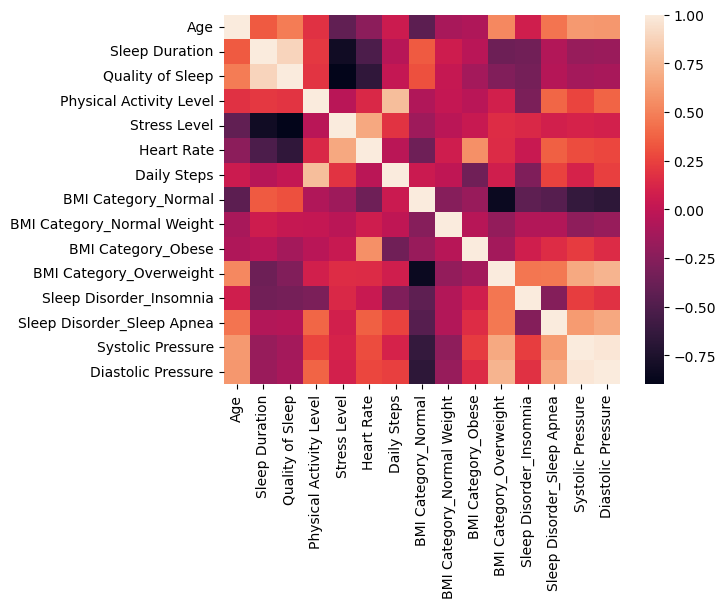

In [15]:
sns.heatmap(health.corr())

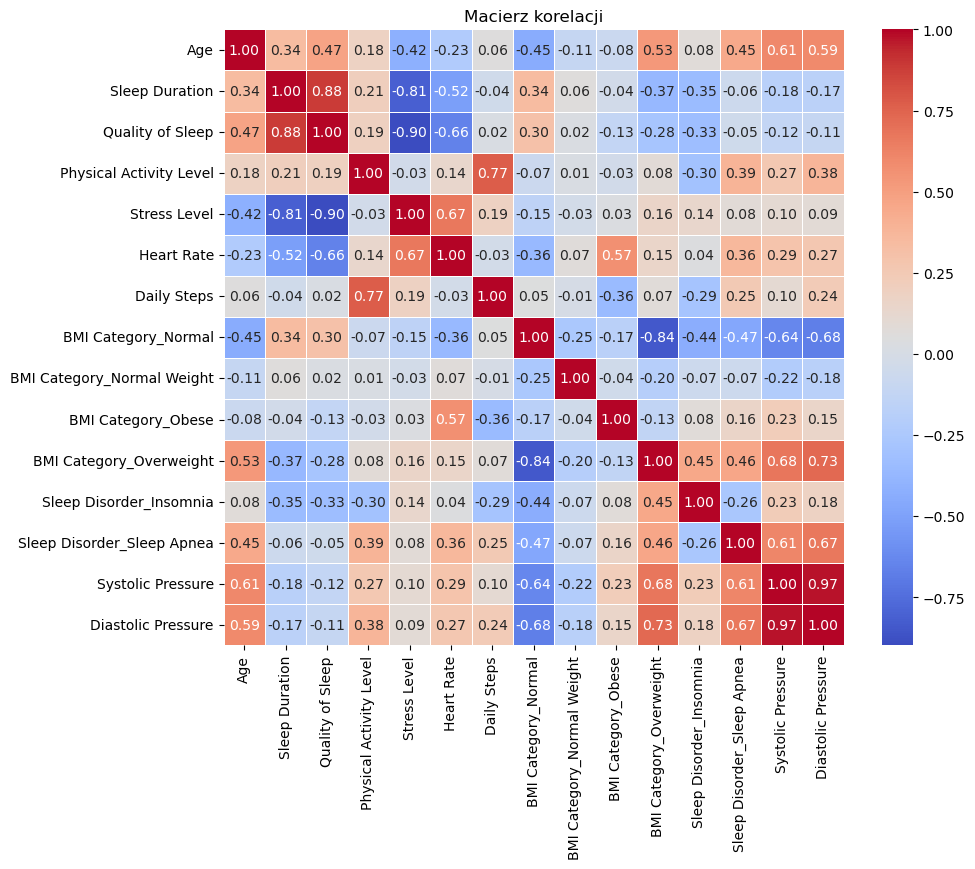

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(health.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Macierz korelacji')
plt.show()

# Interpretacja macierzy korelacji
Chcemy wiedzieć jakie czynniki mają wpływ na jakość snu. 

Z macierzy korelacji możemy odczytać, że istnieje bardzo silna dodatnia korelacja między czasem snu (Sleep Duration), a jakością snu. Oznacza to, że dłuższy czas snu jest związany z lepszą jakością snu. Widzimy również, że istnieje bardzo silna ujemna korelacja między poziomem stresu (Stress Level) a jakością snu (Quality of Sleep). Oznacza to, że kiedy poziom stresu wzrasta, jakość snu znacząco się pogarsza.

Umiarkowana dodatnia korelacja istnieje pomiędzy wiekiem a jakością snu, co sugeruje, że wiek może mieć wpływ ma lepszą jakość snu.
Umiarkowana ujemna korelacja między ciśnieniem, a jakością snu, mówi że wyższe ciśnienie powoduje gorszą jakość snu.

Na jakość snu wpływu nie mają (korelacja bliska zeru) dzienna liczba kroków, wskaźnik BMI, bezdech senny oraz ciśnienie rozkurczowe.

Podsumowując czas snu oraz wiek wpływają na lepszą jakość snu, natomiast stres oraz wyższe ciśnienie powodują pogorszenie snu.

Wnioskując na podstawie obu macierzy korelacji usuwamy z tabeli kolumny z wartościami, które mają najmniejszą korelację z wartościami kolumny 'Quality of Sleep'.

In [17]:
health = health.drop(['Daily Steps', 'BMI Category_Normal Weight', 'BMI Category_Obese', 'BMI Category_Overweight', 'Sleep Disorder_Sleep Apnea', 'Systolic Pressure', 'Diastolic Pressure'], axis = 1)

<Axes: xlabel='Quality of Sleep', ylabel='Sleep Duration'>

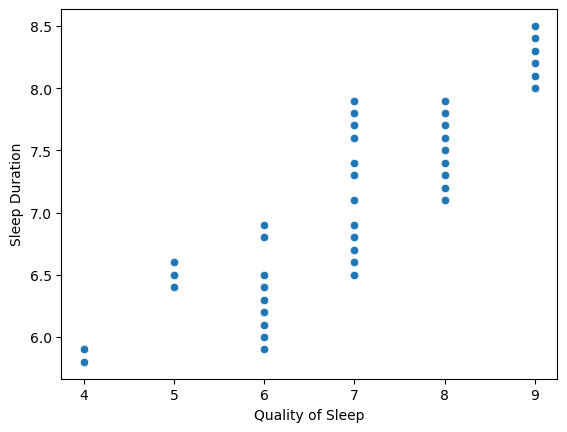

In [18]:
sns.scatterplot(x='Quality of Sleep', y='Sleep Duration', data=health)

# Model - uczenie nadzorowane:

Zaczniemy od prostego modelu regresji liniowej.

In [37]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X = health[['Age', 'Sleep Duration', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'BMI Category_Normal', 'Sleep Disorder_Insomnia']]
y = health['Quality of Sleep']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared Score:', r2)

Mean Squared Error: 0.07154831730087621
R-squared Score: 0.9525737349967678


Z wyników testu widzimy, że nasz model regresji liniowej jest bardzo dobrze dopasowany do danych.

# Model - uczenie bez nadzoru:

In [52]:
import tensorflow as tf

# Model
# imput layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(7,1), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model.add

<bound method Sequential.add of <Sequential name=sequential_9, built=True>>

In [53]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 7, 128)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [57]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 28.5705 
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 27.5744 
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 26.8010 
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 25.9198 
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 25.1324 
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 23.7784 
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 22.5027 
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 20.3378 
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 19.7861 
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 17.7108 


In [58]:
model.evaluate(X_test, y_test, verbose = 2)

3/3 - 0s - 7ms/step - accuracy: 0.0000e+00 - loss: 14.4437


[14.443679809570312, 0.0]